<a href="https://colab.research.google.com/github/BrunaFerreira/Mestrado_UNIFESP/blob/main/Resnet_TL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 0. Bibliotecas a serem utilizadas


In [17]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import PIL
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import os
import shutil
from sklearn.model_selection import train_test_split
import random
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt

## 2. Leitura dos dados (imagens de glandulas salivares)

In [18]:
df = pd.read_csv('/content/drive/MyDrive/0_Mestrado_unifesp/3_Pesquisa/Experimentos/Code/HarmonicSS_Split.csv')
df.head()

,Center,ID,Gland_Type,Machine,DeVita_Score,Omeract_Score,Sex,Age,Disease_Duration,Label_pSS,Image,Faixa_Etaria,Base
0,Udine (Italy),1,submandibular,samsung,3,3,F,72.0,18,1,001.jpg,Acima de 40,train
1,Udine (Italy),2,parotid,samsung,2,3,F,72.0,18,1,002.jpg,Acima de 40,test
2,Udine (Italy),3,parotid,samsung,3,3,F,59.0,1,0,003.jpg,Acima de 40,train
3,Udine (Italy),4,parotid,samsung,0,0,F,65.0,8,0,004.jpg,Acima de 40,train
4,Udine (Italy),5,submandibular,samsung,0,0,F,65.0,8,0,005.jpg,Acima de 40,train


### Pre Processar imagens para usar na VGG

In [19]:
dir = '/content/drive/MyDrive/0_Mestrado_unifesp/3_Pesquisa/Experimentos/Code/dataset'

In [20]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

train_data = ImageFolder(dir + '/train', transform=transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

## Treinamento

### Instancia Modelo

In [21]:
import torch
import torch.nn as nn
import torchvision.models as models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Modelo VGG16 com pesos pré-treinados
model = models.resnet18(pretrained=True)

# Congelar todas as camadas convolucionais
for param in model.parameters():
    param.requires_grad = False

# Substituir a última camada totalmente conectada (fc) para 2 classes
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)

# Enviar para GPU (se disponível)
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Treino Modelo

In [22]:
import torch.optim as optim

# === FUNÇÃO DE PERDA E OTIMIZADOR ===

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.0001)


def train(model, loader, epochs=5):
    train_loss_history = []
    train_acc_history = []
    epoch_hist = []
    model.to(device)
    model.train()

    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        total = 0

        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        avg_loss = total_loss / len(loader)
        accuracy = correct / total

        train_loss_history.append(avg_loss)
        train_acc_history.append(accuracy)
        epoch_hist.append(epoch+1)

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

    return (epoch_hist, train_loss_history,train_acc_history)

In [23]:
import time

start_time = time.time()
epochs_, loss_train,train_acc = train(model, train_loader, epochs=50)
end_time = time.time()

print(f"Tempo de treinamento: {end_time - start_time} segundos")

Epoch [1/50], Loss: 0.5806, Accuracy: 0.7207
Epoch [2/50], Loss: 0.4785, Accuracy: 0.8268
Epoch [3/50], Loss: 0.4240, Accuracy: 0.8547
Epoch [4/50], Loss: 0.4003, Accuracy: 0.8659
Epoch [5/50], Loss: 0.4102, Accuracy: 0.8659
Epoch [6/50], Loss: 0.4182, Accuracy: 0.8659
Epoch [7/50], Loss: 0.4122, Accuracy: 0.8659
Epoch [8/50], Loss: 0.3993, Accuracy: 0.8659
Epoch [9/50], Loss: 0.4176, Accuracy: 0.8659
Epoch [10/50], Loss: 0.3931, Accuracy: 0.8659
Epoch [11/50], Loss: 0.3851, Accuracy: 0.8659
Epoch [12/50], Loss: 0.3658, Accuracy: 0.8659
Epoch [13/50], Loss: 0.3680, Accuracy: 0.8659
Epoch [14/50], Loss: 0.3708, Accuracy: 0.8659
Epoch [15/50], Loss: 0.3620, Accuracy: 0.8659
Epoch [16/50], Loss: 0.3689, Accuracy: 0.8659
Epoch [17/50], Loss: 0.3727, Accuracy: 0.8659
Epoch [18/50], Loss: 0.3572, Accuracy: 0.8659
Epoch [19/50], Loss: 0.3594, Accuracy: 0.8659
Epoch [20/50], Loss: 0.3674, Accuracy: 0.8659
Epoch [21/50], Loss: 0.3383, Accuracy: 0.8659
Epoch [22/50], Loss: 0.3518, Accuracy: 0.86

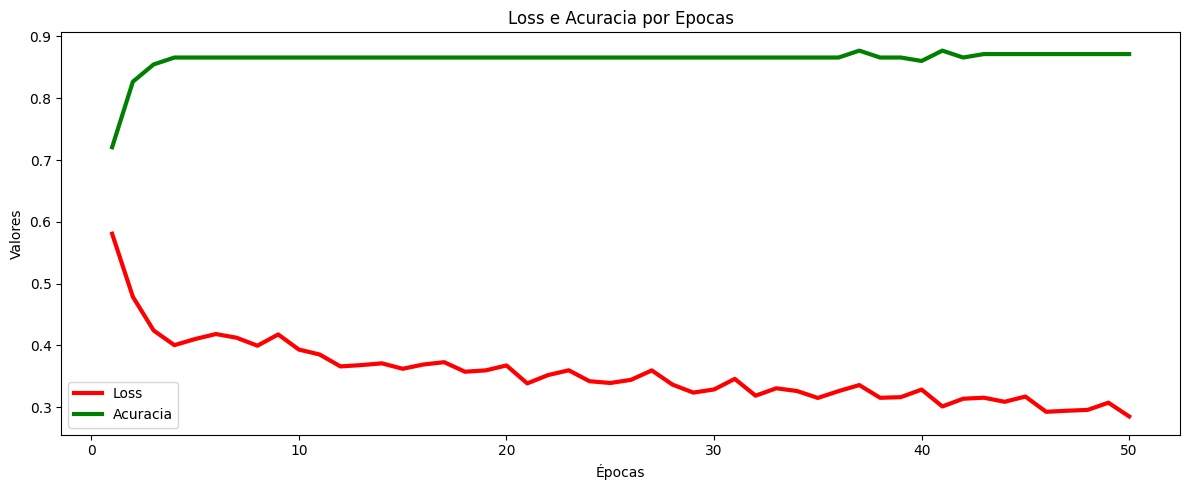

In [24]:
plt.figure(figsize=(12, 5))

# Gráfico de Loss
#plt.subplot(1, 2, 1)
plt.plot(epochs_, loss_train, label='Loss', linewidth=3, color = 'red')
plt.title('Loss e Acuracia por Epocas')

# Gráfico de Acurácia
#plt.subplot(1, 2, 2)
plt.plot(epochs_, train_acc, label='Acuracia', linewidth=3, color = 'green')
plt.title('Loss e Acuracia por Epocas')
plt.xlabel('Épocas')
plt.ylabel('Valores')
plt.legend()
plt.tight_layout()
plt.show()

### Inferencia conjunto de teste

In [25]:
from PIL import Image
import numpy as np
# Pasta com imagens
dir_test = dir + "/test"

# Classes (ordem tem que bater com a usada no treinamento)
classes = ['0', '1']

# Guardar resultados
resultados = []

with torch.no_grad():
    for nome_arquivo in os.listdir(dir_test):
        if nome_arquivo.endswith(('.png', '.jpg', '.jpeg', '.tif', '.bmp')):
            caminho_imagem = os.path.join(dir_test, nome_arquivo)

            # Abrir imagem e aplicar transform
            imagem = Image.open(caminho_imagem).convert("RGB")
            imagem_tensor = transform(imagem).unsqueeze(0).to(device)

            # Predição
            output = model(imagem_tensor)
            probs = torch.softmax(output, dim=1).cpu().numpy()[0]
            classe_predita = np.argmax(probs)
            conf = probs[classe_predita]

            resultados.append({
                'arquivo': nome_arquivo,
                'label_previsto': classes[classe_predita],
                'probabilidade': conf
            })


In [26]:
test_df = df[df['Base']=='test']
previsoes  = pd.DataFrame(resultados)
previsoes.columns = ['Image', 'label_previsto', 'Probability']
result = pd.merge(test_df, previsoes, on="Image", how="left")
result.head()

,Center,ID,Gland_Type,Machine,DeVita_Score,Omeract_Score,Sex,Age,Disease_Duration,Label_pSS,Image,Faixa_Etaria,Base,label_previsto,Probability
0,Udine (Italy),2,parotid,samsung,2,3,F,72.0,18,1,002.jpg,Acima de 40,test,1,0.904159
1,Udine (Italy),7,submandibular,samsung,0,0,F,55.0,5,1,007.jpg,Acima de 40,test,1,0.904333
2,Udine (Italy),13,parotid,samsung,2,2,M,66.0,5,1,013.jpg,Acima de 40,test,1,0.907465
3,Udine (Italy),14,parotid,samsung,0,0,F,74.0,13,1,014.jpg,Acima de 40,test,1,0.909124
4,Udine (Italy),16,submandibular,samsung,0,0,F,65.0,11,0,016.jpg,Acima de 40,test,1,0.906458


### Avaliação

In [27]:
def metricas (df, col_label, col_pred):

  auc = roc_auc_score(df[col_label], df[col_pred])
  f1 = f1_score(df[col_label], df[col_pred])
  acuracia = accuracy_score(df[col_label], df[col_pred])
  precision = precision_score(df[col_label], df[col_pred])
  recall = recall_score(df[col_label], df[col_pred])

  return auc*100, f1*100, acuracia*100, precision*100, recall*100

In [28]:
df_fairness  = pd.DataFrame()
result['Label_pSS'] = result['Label_pSS'].astype(int)
result['label_previsto'] = result['label_previsto'].astype(int)

df_fairness['Base_Completa'] = metricas (result, "Label_pSS", "label_previsto")

## Fairness

### Idade

In [29]:
df_age_ate40 = result[result['Age']<=40]
df_fairness['Idade_Ate40'] = metricas (df_age_ate40, "Label_pSS", "label_previsto")

df_age_mais40 = result[result['Age']>40]
df_fairness['Idade_Mais40'] = metricas (df_age_mais40, "Label_pSS", "label_previsto")

df_fairness

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


,Base_Completa,Idade_Ate40,Idade_Mais40
0,50.000000,NaN,50.000000
1,92.857143,100.0,92.105263
2,86.666667,100.0,85.365854
3,86.666667,100.0,85.365854
4,100.000000,100.0,100.000000


### Sexo

In [30]:
df_sex_F = result[result['Sex']== 'F']
df_fairness['Sexo_F'] = metricas (df_age_ate40, "Label_pSS", "label_previsto")

df_sex_M = result[result['Sex']== 'M']
df_fairness['Sexo_M'] = metricas (df_age_mais40, "Label_pSS", "label_previsto")

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


In [31]:
df_fairness.set_index(pd.Index(['AUC', 'F1', 'Acuracia', 'Precision', 'Recall']), inplace=True)
df_fairness

,Base_Completa,Idade_Ate40,Idade_Mais40,Sexo_F,Sexo_M
AUC,50.000000,NaN,50.000000,NaN,50.000000
F1,92.857143,100.0,92.105263,100.0,92.105263
Acuracia,86.666667,100.0,85.365854,100.0,85.365854
Precision,86.666667,100.0,85.365854,100.0,85.365854
Recall,100.000000,100.0,100.000000,100.0,100.000000


In [32]:
df_age_ate40.shape


(4, 15)